# Rotten Tomato Reviews

### Ryan Huang, Oliver Northing, Maria Zhang

# Rotten Tomatoes Sentiment Classification  
Classical TF-IDF Models and DistilBERT Fine-Tuning

This notebook contains both classical machine learning models (TF-IDF + linear models / XGBoost with cross-validation) and a fine-tuned DistilBERT model.

Note:
- GridSearchCV and DistilBERT training are computationally intensive.
- All reported results are shown directly in the notebook outputs.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
import torch.nn as nn
import nltk

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from wordcloud import WordCloud
from tqdm.auto import tqdm
from torch.nn.utils.rnn import pad_sequence
from nltk.corpus import stopwords

import sys
sys.modules['datasets'] = None
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Dataset

In [2]:
df = pd.read_csv("data_rt.csv")

print("First 5 rows:")
display(df.head())

print("\nColumn names:")
print(df.columns)

print("\nMissing values:")
print(df.isna().sum())

print("\nReview length stats:")
print(df['reviews'].str.len().describe())

# Class distribution
df['labels'].value_counts(normalize=True)


First 5 rows:


,reviews,labels
0,"simplistic , silly and tedious .",0
1,"it's so laddish and juvenile , only teenage bo...",0
2,exploitative and largely devoid of the depth o...,0
3,[garbus] discards the potential for pathologic...,0
4,a visually flashy but narratively opaque and e...,0



Column names:
Index(['reviews', 'labels'], dtype='object')

Missing values:
reviews    0
labels     0
dtype: int64

Review length stats:
count    10662.000000
mean       115.156256
std         51.199546
min          5.000000
25%         77.000000
50%        112.000000
75%        150.000000
max        269.000000
Name: reviews, dtype: float64


labels
0    0.5
1    0.5
Name: proportion, dtype: float64

## Word Clouds

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ryanh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


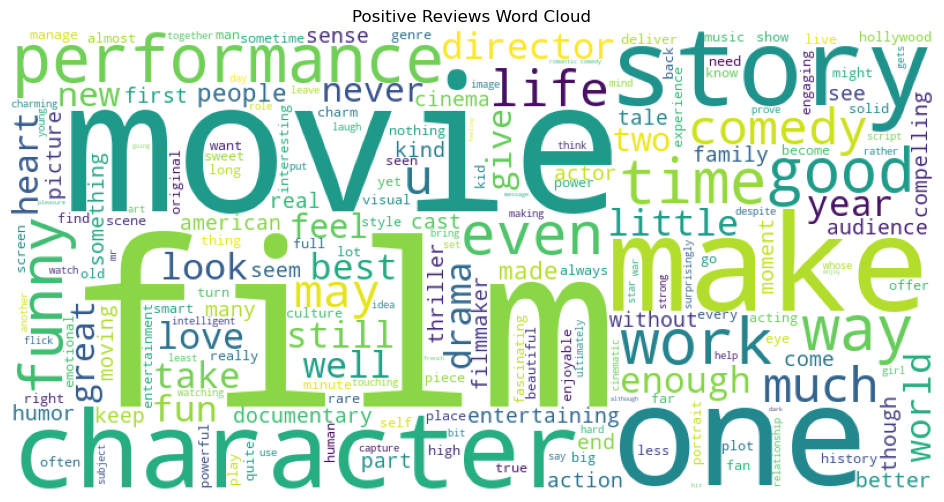

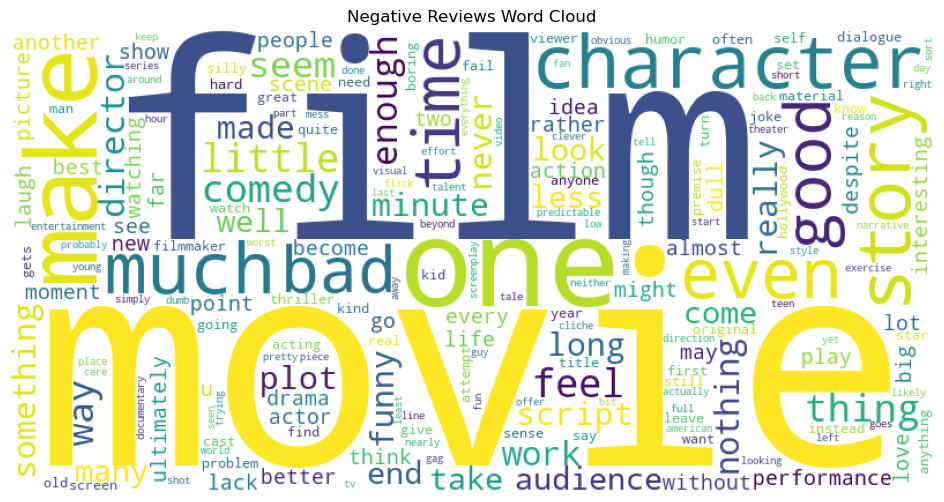

In [4]:
nltk.download('stopwords')
stop = set(stopwords.words("english"))

def clean_tokens(text):
    tokens = re.findall(r"\b\w+\b", text.lower())
    return [t for t in tokens if t not in stop]

df['clean_tokens'] = df['reviews'].apply(clean_tokens)

pos_tokens = [w for tokens in df[df['labels']==1]['clean_tokens'] for w in tokens]
neg_tokens = [w for tokens in df[df['labels']==0]['clean_tokens'] for w in tokens]

pos_text = " ".join([" ".join(tokens) for tokens in df[df['labels']==1]['clean_tokens']])
neg_text = " ".join([" ".join(tokens) for tokens in df[df['labels']==0]['clean_tokens']])

plt.figure(figsize=(12,6))
wc_pos = WordCloud(width=800, height=400, background_color="white").generate(pos_text)
plt.imshow(wc_pos); plt.axis("off")
plt.title("Positive Reviews Word Cloud")
plt.show()

plt.figure(figsize=(12,6))
wc_neg = WordCloud(width=800, height=400, background_color="white").generate(neg_text)
plt.imshow(wc_neg); plt.axis("off")
plt.title("Negative Reviews Word Cloud")
plt.show()

## Training and Testing Split

In [5]:
X = df['reviews']
y = df['labels']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

len(X_train), len(X_test)

(8529, 2133)

## Classical Machine Learning Pipelines

In [ ]:
# Train Logistic Regression
lr = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', LogisticRegression(max_iter=1000))
])
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)


# Train Linear SVM
svm = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', LinearSVC())
])
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)


# Train XGBoost
xgb = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', XGBClassifier(eval_metric='logloss'))
])
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)



# GridSearchCV — Logistic Regression
lr_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

lr_param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__min_df': [1, 2],
    'tfidf__max_df': [0.9, 1.0],
    'clf__C': [0.1, 1, 10],
    'clf__class_weight': [None, 'balanced']
}

lr_gs = GridSearchCV(
    lr_pipe, lr_param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=2
)

lr_gs.fit(X_train, y_train)
lr_best = lr_gs.best_estimator_
lr_preds = lr_best.predict(X_test)

print("Best LR params:", lr_gs.best_params_)



# GridSearchCV — Linear SVM
svm_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC())
])

svm_param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__min_df': [1, 2],
    'tfidf__max_df': [0.9, 1.0],
    'clf__C': [0.1, 1, 10]
}

svm_gs = GridSearchCV(
    svm_pipe, svm_param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=2
)

svm_gs.fit(X_train, y_train)
svm_best = svm_gs.best_estimator_
svm_preds = svm_best.predict(X_test)

print("Best SVM params:", svm_gs.best_params_)



# GridSearchCV — XGBoost
xgb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', XGBClassifier(eval_metric='logloss'))
])

xgb_param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__min_df': [1, 2],
    'tfidf__max_df': [0.9, 1.0],
    'clf__max_depth': [3, 5],
    'clf__gamma': [0, 0.25]
}

xgb_gs = GridSearchCV(
    xgb_pipe, xgb_param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=2
)

xgb_gs.fit(X_train, y_train)
xgb_best = xgb_gs.best_estimator_
xgb_preds = xgb_best.predict(X_test)

print("Best XGB params:", xgb_gs.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best LR params: {'clf__C': 10, 'clf__class_weight': None, 'tfidf__max_df': 0.9, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best SVM params: {'clf__C': 1, 'tfidf__max_df': 0.9, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best XGB params: {'clf__gamma': 0.25, 'clf__max_depth': 5, 'tfidf__max_df': 0.9, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}


## Best Parameters

In [ ]:
# Function: Extract Top 5 Hyperparameters from GridSearchCV
def get_top_results(gs, top_n=5):
    results = pd.DataFrame({
        'params': gs.cv_results_['params'],
        'mean_test_f1': gs.cv_results_['mean_test_score'],
        'std_test_f1': gs.cv_results_['std_test_score'],
    })

    # Sort by F1 descending
    results_sorted = results.sort_values(by='mean_test_f1', ascending=False)
    
    return results_sorted.head(top_n)
    
def expand_params(df):
    param_df = df["params"].apply(pd.Series)
    return pd.concat([param_df, df.drop(columns=["params"])], axis=1)



# Top 5 Logistic Regression Results
print("Top 5 Logistic Regression Parameter Sets:")
expanded_lr = expand_params(top_lr)
display(expanded_lr)




# Top 5 SVM Results
print("Top 5 SVM Parameter Sets:")
expanded_svm = expand_params(top_svm)
display(expanded_svm)




# Top 5 XGBoost Results
print("Top 5 XGBoost Parameter Sets:")
expanded_xgb = expand_params(top_xgb)
display(expanded_xgb)

Top 5 Logistic Regression Parameter Sets:


,clf__C,clf__class_weight,tfidf__max_df,tfidf__min_df,tfidf__ngram_range,mean_test_f1,std_test_f1,mean_test_accuracy
33,10,None,0.9,1,"(1, 2)",0.769492,0.007242,None
37,10,None,1.0,1,"(1, 2)",0.769492,0.007242,None
45,10,balanced,1.0,1,"(1, 2)",0.769056,0.006950,None
41,10,balanced,0.9,1,"(1, 2)",0.769056,0.006950,None
43,10,balanced,0.9,2,"(1, 2)",0.767507,0.007763,None


Top 5 SVM Parameter Sets:


,clf__C,tfidf__max_df,tfidf__min_df,tfidf__ngram_range,mean_test_f1,std_test_f1,mean_test_accuracy
13,1,1.0,1,"(1, 2)",0.771347,0.006987,None
9,1,0.9,1,"(1, 2)",0.771347,0.006987,None
17,10,0.9,1,"(1, 2)",0.771180,0.010183,None
21,10,1.0,1,"(1, 2)",0.771180,0.010183,None
11,1,0.9,2,"(1, 2)",0.762703,0.009792,None


Top 5 XGBoost Parameter Sets:


,clf__gamma,clf__max_depth,tfidf__max_df,tfidf__min_df,tfidf__ngram_range,mean_test_f1,std_test_f1,mean_test_accuracy
25,0.25,5,0.9,1,"(1, 2)",0.695406,0.013081,None
29,0.25,5,1.0,1,"(1, 2)",0.695406,0.013081,None
28,0.25,5,1.0,1,"(1, 1)",0.694571,0.008349,None
24,0.25,5,0.9,1,"(1, 1)",0.694571,0.008349,None
13,0.00,5,1.0,1,"(1, 2)",0.693256,0.006773,None


## Classical Machine Learning Results

,Model,Accuracy,F1 Score
0,Linear SVM,0.774496,0.775758
1,Logistic Regression,0.774027,0.776022
2,XGBoost,0.704173,0.715894


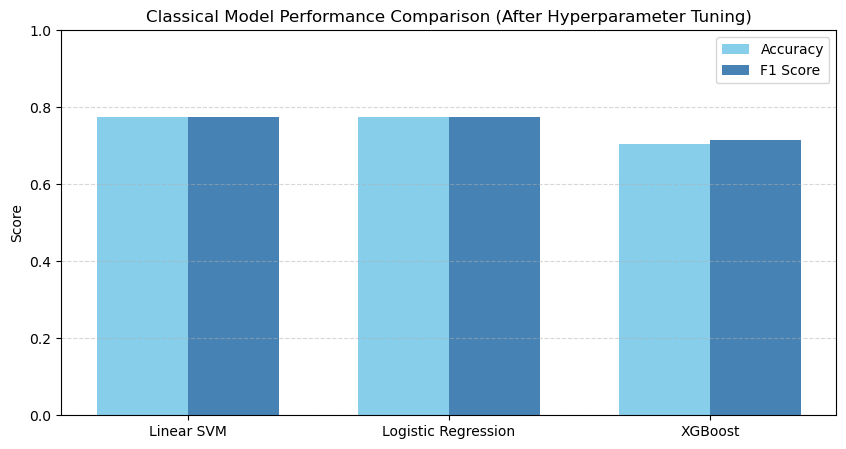


=== Linear SVM ===


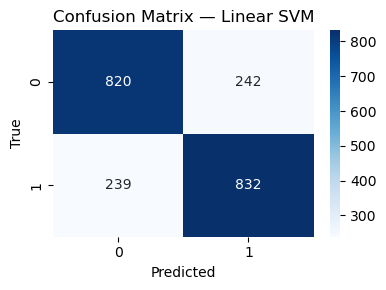


=== Logistic Regression ===


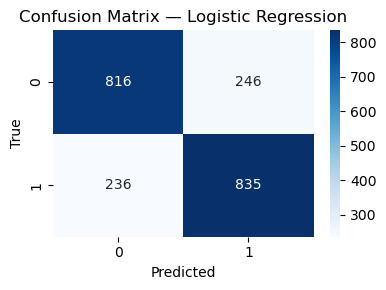


=== XGBoost ===


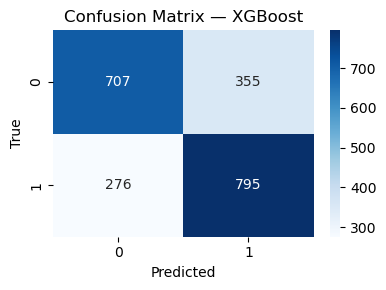

In [ ]:

# Classical Model Comparison Table
classical_results_df = pd.DataFrame({
    "Model": ["Linear SVM", "Logistic Regression", "XGBoost"],
    
    "Accuracy": [
        accuracy_score(y_test, svm_preds),
        accuracy_score(y_test, lr_preds),
        accuracy_score(y_test, xgb_preds)
    ],
    
    "F1 Score": [
        f1_score(y_test, svm_preds),
        f1_score(y_test, lr_preds),
        f1_score(y_test, xgb_preds)
    ]
})

display(classical_results_df)




plt.figure(figsize=(10,5))
bar_width = 0.35
x = np.arange(len(classical_results_df))

plt.bar(x - bar_width/2, classical_results_df["Accuracy"], 
        width=bar_width, label="Accuracy", color="skyblue")

plt.bar(x + bar_width/2, classical_results_df["F1 Score"], 
        width=bar_width, label="F1 Score", color="steelblue")

plt.xticks(x, classical_results_df["Model"])
plt.title("Classical Model Performance Comparison (After Hyperparameter Tuning)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.show()



# Confusion Matrices for Classical Models 
models = {
    "Linear SVM": svm_preds,
    "Logistic Regression": lr_preds,
    "XGBoost": xgb_preds
}

for model_name, preds in models.items():
    print(f"\n{model_name}")
    cm = confusion_matrix(y_test, preds)
    
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix — {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


# Deep Learning Model - DistilBERT

## Tokenizer

In [17]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Encode training data
train_encodings = tokenizer(
    X_train.tolist(),
    truncation=True,
    padding=True,
    max_length=256
)

# Encode test data
test_encodings = tokenizer(
    X_test.tolist(),
    truncation=True,
    padding=True,
    max_length=256
)

## PyTorch Dataset Generation

In [18]:
class RTDataset(Dataset):
    """
    Custom dataset wrapping tokenized text + labels.
    Returns dictionaries compatible with DistilBERT.
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.values  # convert pandas Series to numpy array

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert tokenizer outputs to tensors + add label
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

## Dataloaders Setup

In [19]:
train_dataset = RTDataset(train_encodings, y_train)
test_dataset  = RTDataset(test_encodings, y_test)

# DataLoader provides batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

len(train_loader), len(test_loader)

(534, 134)

## Loading Model

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2  # binary classification
).to(device)

model 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## Training Loop

In [21]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
epochs = 2

model.train()

for epoch in range(epochs):
    total_loss = 0
    loop = tqdm(train_loader, leave=True)
    
    for batch in loop:
        # Move batch to GPU/CPU
        batch = {k: v.to(device) for k, v in batch.items()}
        
        optimizer.zero_grad()  # clear gradients
        
        # Forward pass through DistilBERT
        outputs = model(**batch)
        loss = outputs.loss
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Track loss
        total_loss += loss.item()
        
        # Progress bar info
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} - Average Loss: {total_loss / len(train_loader):.4f}")


  0%|          | 0/534 [00:00<?, ?it/s]

Epoch 1 - Average Loss: 0.4188


  0%|          | 0/534 [00:00<?, ?it/s]

Epoch 2 - Average Loss: 0.2286


## Model Evaluation

DistilBERT Accuracy: 0.8443506797937178
DistilBERT F1: 0.8341658341658341

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      1062
           1       0.90      0.78      0.83      1071

    accuracy                           0.84      2133
   macro avg       0.85      0.84      0.84      2133
weighted avg       0.85      0.84      0.84      2133



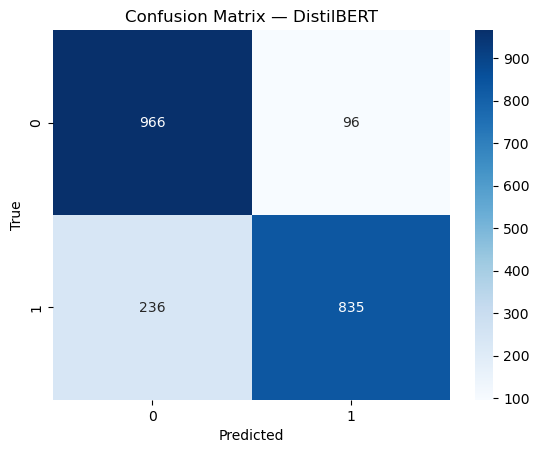

In [ ]:
model.eval()

bert_preds = []        
bert_true_labels = []  

with torch.no_grad():
    for batch in test_loader:
        labels = batch["labels"].numpy()
        bert_true_labels.extend(labels)

        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        # Predictions
        logits = outputs.logits
        bert_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())

# Metrics
print("DistilBERT Accuracy:", accuracy_score(bert_true_labels, bert_preds))
print("DistilBERT F1:", f1_score(bert_true_labels, bert_preds))
print("\nClassification Report:")
print(classification_report(bert_true_labels, bert_preds))

# Confusion Matrix
cm = confusion_matrix(bert_true_labels, bert_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix — DistilBERT")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Final Results

In [23]:
final_results = pd.DataFrame({
    'Model': [
        'Logistic Regression',
        'SVM',
        'XGBoost',
        'DistilBERT'
    ],
    
    'Accuracy': [
        accuracy_score(y_test, lr_preds),
        accuracy_score(y_test, svm_preds),
        accuracy_score(y_test, xgb_preds),
        accuracy_score(bert_true_labels, bert_preds)
    ],
    
    'F1 Score': [
        f1_score(y_test, lr_preds),
        f1_score(y_test, svm_preds),
        f1_score(y_test, xgb_preds),
        f1_score(bert_true_labels, bert_preds)
    ]
})

final_results

,Model,Accuracy,F1 Score
0,Logistic Regression,0.774027,0.776022
1,SVM,0.774496,0.775758
2,XGBoost,0.704173,0.715894
3,DistilBERT,0.844351,0.834166
